In [52]:
from kaggle_environments import make
import gym
import numpy as np

class ConnectX(gym.Env):
    """Custom Environment that follows gym interface"""

    def __init__(self, opponent_type):
        self.env = make("connectx", debug=True)
        self.trainer = self.env.train([None, opponent_type])
        self.obs = None
        self.action_space = gym.spaces.Discrete(self.env.configuration.columns)
        self.observation_space = gym.spaces.Box(0, 2, shape=(self.env.configuration.rows, self.env.configuration.columns), 
                                                dtype=np.float32)

    def get_kaggle_env(self):
        return self.env

    def step(self, action):
        # Wrap kaggle environment.step()
        if self.obs[0][action] != 0:
            r = -1 # punish illegal move
            d = False
            o = self.obs
        else:
            o, r, d, _ = self.trainer.step(int(action))
            o = np.reshape(np.array(o['board']), (self.env.configuration.rows, self.env.configuration.columns))
            self.obs = o

        return o, float(r), bool(d), {}

    def reset(self):
        o = self.trainer.reset()
        self.obs = np.reshape(np.array(o['board']), (self.env.configuration.rows, self.env.configuration.columns))
        return self.obs

    def render(self, **kwargs):
        return self.env.render(**kwargs)


In [90]:
import numpy as np
import matplotlib.pyplot as plt
import random
from functools import partial
from IPython.display import clear_output

%matplotlib inline

def show_progress(avg_returns):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 1, 1)
    plt.plot(*zip(*avg_returns), label='Mean return')
    plt.legend(loc=4)
    plt.grid()
    plt.show()

def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f'{method_name}')
        plt.legend()
    plt.grid()
    plt.show()

In [91]:
env = ConnectX('negamax')
# env = Monitor(gym_env, log_dir, allow_early_resets=True)
# env = DummyVecEnv([lambda: env])
env.reset()

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [92]:
class Model:
    def __init__(self, n_states, n_actions, seed):
        self.mask_state = np.zeros([n_states], dtype=int)
        self.mask_state_action = np.zeros([n_states, n_actions], dtype=int)
        self.r = np.zeros_like(self.mask_state_action, dtype=float)
        self.next_s = np.zeros_like(self.mask_state_action, dtype=int)
        self._rng = np.random.default_rng(seed)

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        self.mask_state[s] = 1
        self.mask_state_action[s, a] = 1
        self.r[s, a] = r
        self.next_s[s, a] = next_s
        # Store reward and next state
        return r

    def sample(self) -> tuple[int, int, float, int]:
        """
        returns s, a, r, next_s
        """
        s = self._rng.choice(self.mask_state.nonzero()[0])
        a = self._rng.choice(self.mask_state_action[s].nonzero()[0])
        return s, a, self.r[s,a], self.next_s[s,a]


In [93]:
class DynaQAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, f_model, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.model = f_model(n_states, n_actions, seed=seed)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)
        
    def act(self, s):
        s = s.reshape(-1)
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps:
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])%self.n_actions  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, update_model: bool):
        s = s.reshape(-1)
        s_n = s_n.reshape(-1)
        # Обновите модель, если нужно, реализуйте шаг Q-обучения
        ####### Здесь ваш код ########
        if update_model:
            self.model.add(s,a,r,s_n)
        # alpha = lr
        self.Q[s,a] += self.lr * (r + self.gamma*np.max(self.Q[s_n])- self.Q[s, a])
        ##############################
        
    def dream(self, max_steps):
        for _ in range(max_steps):
            # Добавьте шаг обучения с использованием модели
            ####### Здесь ваш код ########
            s, a, r, next_s = self.model.sample()
            self.update(s, a, r, next_s, False)
            ##############################

In [94]:
def train(env, agent, n_episodes, on_model_updates, seed, show_progress_schedule=50):
    avg_returns, returns_batch = [], []
    rng = np.random.default_rng(seed)

    for i in range(1, n_episodes):
        state = env.reset() #seed=int(rng.integers(10000000)))
        reward, episode_return = 0, 0

        while True:
            action = agent.act(state)
#             print(action)

            # выполняем действие в среде
            next_state, reward, terminated, info = env.step(action)
#             print(state)
            agent.update(state.reshape(-1), action, reward, next_state.reshape(-1), update_model=True)
            state = next_state
            episode_return += reward
            done = terminated # or truncated
            if done:
                break
            agent.dream(on_model_updates)

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0:
            avg_returns.append((i, np.mean(returns_batch)))
            returns_batch = []
            
            show_progress(avg_returns)
            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
            )

    return avg_returns

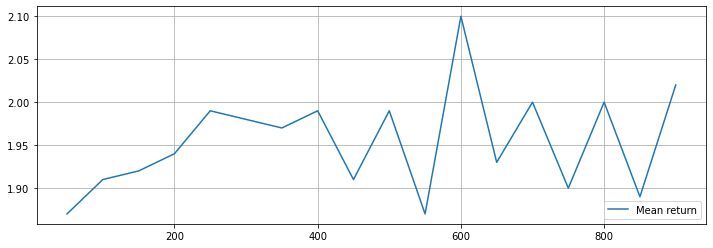

Episode: 900, Return: 2.0, AvgReturn[50]: 2


In [ ]:
seed = 1337
x, y = env.observation_space.shape
agent = DynaQAgent(
    x * y, env.action_space.n , lr=0.1, gamma=0.95, eps=0.1, seed=seed,
    f_model=Model
)

log_q = train(env, agent, n_episodes=20_001, on_model_updates=20, seed=seed, show_progress_schedule=50)